
--- Calculated Property Ratios ---
mu_ratio       : 1.078566
rho_beta_ratio : 0.986028
k_ratio        : 1.091631
rho_cp_ratio   : 0.993850
rho_ratio      : 1.188399
---------------------------------------------

  PART A: Running Ensemble UQ Test
  Case: M = -1.0, lambda = -1.0
  Number of Runs: 10

--- UQ Run 1/10 (Seed 42) ---
    Cf: 0.256753, Nu: 0.298896, Loss: 2.84e-06, Time: 560.6s
--- UQ Run 2/10 (Seed 43) ---
    Cf: 0.256425, Nu: 0.301840, Loss: 1.92e-05, Time: 564.2s
--- UQ Run 3/10 (Seed 44) ---
    Cf: 0.264037, Nu: 0.299383, Loss: 2.82e-06, Time: 559.0s
--- UQ Run 4/10 (Seed 45) ---
    Cf: 0.255049, Nu: 0.297386, Loss: 8.78e-06, Time: 552.8s
--- UQ Run 5/10 (Seed 46) ---


    Cf: 0.257687, Nu: 0.299782, Loss: 1.40e-05, Time: 552.7s
--- UQ Run 6/10 (Seed 47) ---


    Cf: 0.261847, Nu: 0.298971, Loss: 3.03e-06, Time: 558.6s
--- UQ Run 7/10 (Seed 48) ---
    Cf: 0.256855, Nu: 0.299606, Loss: 9.63e-06, Time: 552.3s
--- UQ Run 8/10 (Seed 49) ---
    Cf: 0.255691, Nu: 0.298143, Loss: 1.02e-05, Time: 544.8s
--- UQ Run 9/10 (Seed 50) ---
    Cf: 0.256401, Nu: 0.298801, Loss: 7.34e-06, Time: 558.4s
--- UQ Run 10/10 (Seed 51) ---
    Cf: 0.255673, Nu: 0.298314, Loss: 6.30e-06, Time: 566.2s

**************************************************
  ENSEMBLE UQ RESULTS (for Rebuttal)
**************************************************
Skin Friction (Cf):
  Mean: 0.257642
  Std Dev: 0.00278234
Nusselt Number (Nu):
  Mean: 0.299112
  Std Dev: 0.00113693
**************************************************


  PART B: Running Main Parameter Sweep


   Sweeping λ for M = 0.0

--- Case: λ=-1.300, M=0.0 ---
Stage 1: Adam training...
  Epoch 300/1500, Loss = 1.3042e-03, λ_bc = 0.36
  Epoch 600/1500, Loss = 2.8366e-04, λ_bc = 0.23
  Epoch 900/1500, Loss = 6.9709e-05, λ_b

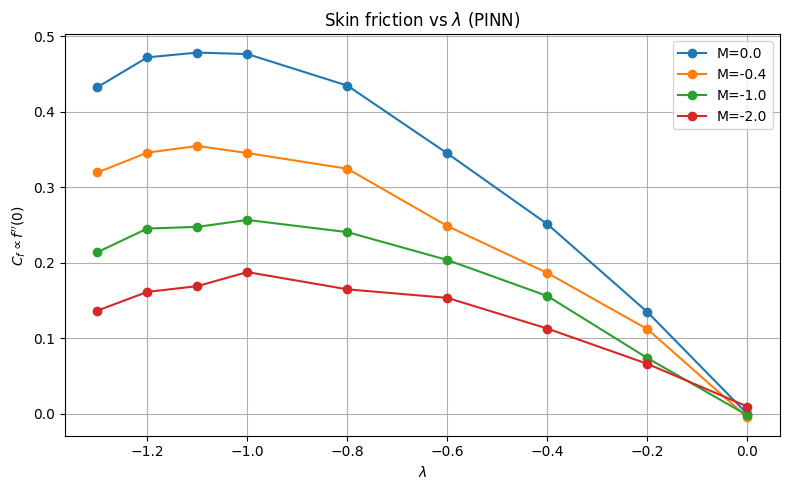

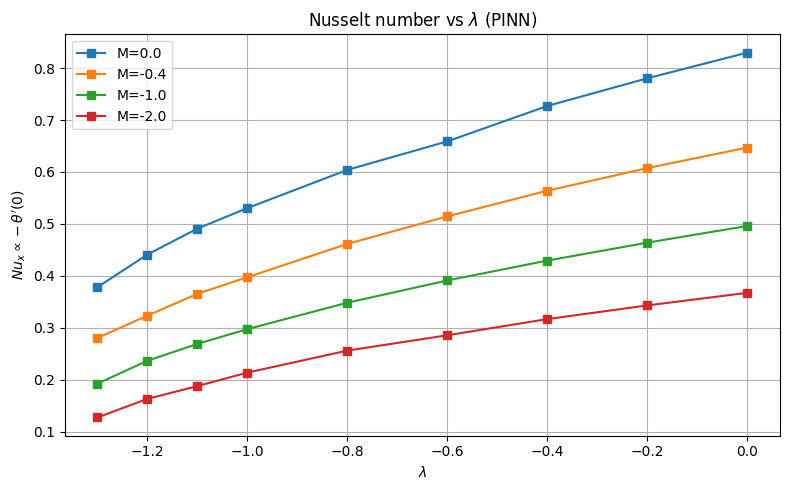

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import tensorflow_probability as tfp

# ================================================================
# 0. Global settings
# ================================================================
tf.keras.backend.set_floatx('float64')

# ================================================================
# 1. Physical Properties: Hybrid nanofluid (phi1 = 0.01, phi2 = 0.02)
# ================================================================
phi1 = 0.01  # Al2O3
phi2 = 0.02  # Cu

# Base fluid (Water) properties
rho_f   = 997.1
Cp_f    = 4179.0
k_f     = 0.613
beta_f  = 21e-5
mu_f    = 0.001003  # dynamic viscosity of water

# Solid nanoparticle 1 (Al2O3) properties
rho_s1  = 3970.0
Cp_s1   = 765.0
k_s1    = 40.0
beta_s1 = 0.85e-5

# Solid nanoparticle 2 (Cu) properties
rho_s2  = 8933.0
Cp_s2   = 385.0
k_s2    = 400.0  # (Corrected per your note)
beta_s2 = 1.67e-5

# --- Effective properties of intermediate nanofluid (water + Al2O3)
phi_bf = phi1
rho_bf = (1 - phi_bf) * rho_f + phi_bf * rho_s1
Cp_bf  = ((1 - phi_bf) * rho_f * Cp_f + phi_bf * rho_s1 * Cp_s1) / rho_bf
k_bf   = k_f * (k_s1 + 2*k_f - 2*phi_bf*(k_f - k_s1)) / (k_s1 + 2*k_f + phi_bf*(k_f - k_s1))
beta_bf = ((1 - phi_bf) * rho_f * beta_f + phi_bf * rho_s1 * beta_s1) / rho_bf
mu_bf   = mu_f / ((1 - phi_bf)**2.5)

# --- Effective properties of final hybrid nanofluid (water + Al2O3 + Cu)
rho_hnf = (1 - phi2) * rho_bf + phi2 * rho_s2
Cp_hnf  = ((1 - phi2) * rho_bf * Cp_bf + phi2 * rho_s2 * Cp_s2) / rho_hnf
k_hnf   = k_bf * (k_s2 + 2*k_bf - 2*phi2*(k_bf - k_s2)) / (k_s2 + 2*k_bf + phi2*(k_bf - k_s2))
beta_hnf = ((1 - phi2) * rho_bf * beta_bf + phi2 * rho_s2 * beta_s2) / rho_hnf
mu_hnf   = mu_bf / ((1 - phi2)**2.5)

# --- Ratio parameters used in similarity ODEs
ratios = {
    'mu_ratio'      : mu_hnf / mu_f,
    'rho_beta_ratio': (rho_hnf * beta_hnf) / (rho_f * beta_f),
    'k_ratio'       : k_hnf / k_f,
    'rho_cp_ratio'  : (rho_hnf * Cp_hnf) / (rho_f * Cp_f),
    'rho_ratio'     : rho_hnf / rho_f,
}

print("\n--- Calculated Property Ratios ---")
for key, value in ratios.items():
    print(f"{key:<15}: {value:.6f}")
print("-" * 45)

# ================================================================
# 2. Domain and BC setup
# ================================================================
L = 10.0  # truncated similarity domain [0, L]
N_colloc = 250
eta_colloc = tf.convert_to_tensor(
    np.linspace(0.0, L, N_colloc).reshape(-1, 1),
    dtype=tf.float64
)
eta_0 = tf.convert_to_tensor([[0.0]], dtype=tf.float64)
eta_L = tf.convert_to_tensor([[L  ]], dtype=tf.float64)

# Adaptive weight for BC loss (physics weight = 1.0)
adaptive_lambda_bc = tf.Variable(1.0, dtype=tf.float64, trainable=False)

# ================================================================
# 3. Neural Network model
# ================================================================
def build_model():
    """
    4 hidden layers × 128 neurons, tanh activation.
    """
    inputs = tf.keras.Input(shape=(1,))
    x = tf.keras.layers.Dense(128, activation='tanh')(inputs)
    x = tf.keras.layers.Dense(128, activation='tanh')(x)
    x = tf.keras.layers.Dense(128, activation='tanh')(x)
    x = tf.keras.layers.Dense(128, activation='tanh')(x)
    outputs = tf.keras.layers.Dense(2)(x)  # [f(η), θ(η)]
    return tf.keras.Model(inputs=inputs, outputs=outputs)

# ================================================================
# 4. Loss functions: physics + BC
# ================================================================
def get_losses(model, lam, M, **ratios):
    """
    Returns (physics_loss, bc_loss) for given λ, M.
    """
    # --- Physics loss at collocation points ---
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(eta_colloc)
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch(eta_colloc)
            y_pred = model(eta_colloc, training=True)
            f, theta = y_pred[:, 0:1], y_pred[:, 1:2]
        df_deta     = tape1.gradient(f,     eta_colloc)
        dtheta_deta = tape1.gradient(theta, eta_colloc)
    d2f_deta2     = tape2.gradient(df_deta,     eta_colloc)
    d2theta_deta2 = tape2.gradient(dtheta_deta, eta_colloc)
    del tape1, tape2

    # ODEs:
    # f'' = (rho_beta_ratio / mu_ratio) * λ θ'
    # (k_ratio / rho_cp_ratio) θ'' + f θ' = 0
    eq1 = d2f_deta2 - (ratios['rho_beta_ratio'] / ratios['mu_ratio']) * lam * dtheta_deta
    eq2 = (ratios['k_ratio'] / ratios['rho_cp_ratio']) * d2theta_deta2 + f * dtheta_deta
    physics_loss = tf.reduce_mean(tf.square(eq1)) + tf.reduce_mean(tf.square(eq2))

    # --- Boundary condition loss at η=0, η=L ---
    eta_bc = tf.concat([eta_0, eta_L], axis=0)
    with tf.GradientTape(persistent=True) as tape_bc:
        tape_bc.watch(eta_bc)
        y_bc = model(eta_bc, training=True)
        f_bc, theta_bc = y_bc[:, 0:1], y_bc[:, 1:2]
    df_deta_bc     = tape_bc.gradient(f_bc,    eta_bc)
    dtheta_deta_bc = tape_bc.gradient(theta_bc, eta_bc)
    del tape_bc

    # at η=0
    f0      = f_bc[0:1]
    theta0  = theta_bc[0:1]
    dtheta0 = dtheta_deta_bc[0:1]

    # at η=L
    dfL     = df_deta_bc[1:2]
    thetaL  = theta_bc[1:2]

    # BCs:
    # θ(0) = 1
    # f(0) + (k_ratio * rho_ratio) M θ'(0) = 0   (melting condition)
    # f'(L) = 1
    # θ(L) = 0
    bc_res1 = theta0 - 1.0
    bc_res2 = f0 + (ratios['k_ratio'] * ratios['rho_ratio']) * M * dtheta0
    bc_res3 = dfL - 1.0
    bc_res4 = thetaL - 0.0

    bc_loss = (
        tf.reduce_mean(tf.square(bc_res1)) +
        tf.reduce_mean(tf.square(bc_res2)) +
        tf.reduce_mean(tf.square(bc_res3)) +
        tf.reduce_mean(tf.square(bc_res4))
    )

    return physics_loss, bc_loss

def compute_adaptive_loss(model, lam, M, **ratios):
    """
    Total loss with adaptive BC weighting:
        L = L_eq + λ_bc * L_bc
    """
    physics_loss, bc_loss = get_losses(model, lam, M, **ratios)
    return physics_loss + adaptive_lambda_bc * bc_loss

def compute_fixed_loss(model, lam, M, **ratios):
    """
    Total loss with fixed weights (for L-BFGS stage).
    """
    physics_loss, bc_loss = get_losses(model, lam, M, **ratios)
    return physics_loss + 10.0 * bc_loss  # strong BC enforcement

@tf.function
def update_adaptive_weights(model, lam, M, **ratios):
    """
    Simple adaptive scheme: adjust λ_bc so that
    gradient norms of physics and BC contributions
    are roughly balanced.
    """
    with tf.GradientTape(persistent=True) as tape:
        physics_loss, bc_loss = get_losses(model, lam, M, **ratios)
    grads_eq = tape.gradient(physics_loss, model.trainable_variables)
    grads_bc = tape.gradient(bc_loss,    model.trainable_variables)
    del tape

    # Flatten and compute L2 norms
    flat_eq = tf.concat(
        [tf.reshape(g, [-1]) for g in grads_eq if g is not None],
        axis=0
    )
    flat_bc = tf.concat(
        [tf.reshape(g, [-1]) for g in grads_bc if g is not None],
        axis=0
    )
    norm_eq = tf.norm(flat_eq) + 1e-12
    norm_bc = tf.norm(flat_bc) + 1e-12

    # We want: norm_eq ≈ λ_bc * norm_bc  -> λ_bc ≈ norm_eq / norm_bc
    lambda_hat = norm_eq / norm_bc
    alpha = 0.9  # smoothing factor
    adaptive_lambda_bc.assign(alpha * adaptive_lambda_bc + (1.0 - alpha) * lambda_hat)

def train_step_adam(model, optimizer, lam, M, **ratios):
    """
    One Adam step with global-norm gradient clipping.
    """
    with tf.GradientTape() as tape:
        loss = compute_adaptive_loss(model, lam, M, **ratios)
    grads = tape.gradient(loss, model.trainable_variables)
    grads, _ = tf.clip_by_global_norm(grads, 1.0)  # clip L2 norm to 1.0
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

def train_lbfgs(model, lam, M, **ratios):
    """
    L-BFGS minimization of the fixed-weight loss.
    """
    var_list = model.trainable_variables

    def loss_and_grads(w):
        # Unpack flat weights into the model
        shapes = [v.shape for v in var_list]
        sizes  = [tf.size(v).numpy() for v in var_list]
        w_split = tf.split(w, sizes)
        w_reshaped = [tf.reshape(ws, s) for ws, s in zip(w_split, shapes)]
        for var, val in zip(var_list, w_reshaped):
            var.assign(val)

        with tf.GradientTape() as tape:
            loss_value = compute_fixed_loss(model, lam, M, **ratios)
        grads = tape.gradient(loss_value, var_list)
        grads_flat = tf.concat(
            [tf.reshape(g, [-1]) for g in grads if g is not None],
            axis=0
        )
        return loss_value, grads_flat

    w0 = tf.concat([tf.reshape(v, [-1]) for v in var_list], axis=0)
    results = tfp.optimizer.lbfgs_minimize(
        value_and_gradients_function=loss_and_grads,
        initial_position=w0,
        max_iterations=200,      # increase for final runs if needed
        tolerance=1e-8
    )
    return results.objective_value

# ================================================================
# 5. Physical quantities: Cf and Nux
# ================================================================
@tf.function
def compute_physical_quantities(model, k_ratio, mu_ratio):
    """
    Skin friction ~ f''(0) and Nusselt number ~ -θ'(0).
    """
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(eta_0)
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch(eta_0)
            y0 = model(eta_0, training=False)
            f0, theta0 = y0[:, 0:1], y0[:, 1:2]
        df0     = tape1.gradient(f0,     eta_0)
        dtheta0 = tape1.gradient(theta0, eta_0)
    d2f0 = tape2.gradient(df0, eta_0)
    del tape1, tape2

    Cf  = mu_ratio * d2f0
    Nux = -k_ratio * dtheta0
    return Cf, Nux

# ================================================================
# 6. Main: Ensemble UQ + Sweep
# ================================================================
if __name__ == "__main__":

    # Training settings
    adam_epochs = 1500
    lr = 1e-3

    # ============================================================
    # PART A: ENSEMBLE UNCERTAINTY QUANTIFICATION (UQ)
    # ============================================================
    print("\n" + "="*50)
    print("  PART A: Running Ensemble UQ Test")
    print("  Case: M = -1.0, lambda = -1.0")
    print("  Number of Runs: 10")
    print("="*50 + "\n")

    uq_M = -1.0
    uq_lam = -1.0
    uq_runs = 10

    uq_Cf_results = []
    uq_Nu_results = []

    for i in range(uq_runs):
        run_start = time.time()


        seed_val = 42 + i
        tf.random.set_seed(seed_val)
        np.random.seed(seed_val)

        print(f"--- UQ Run {i+1}/{uq_runs} (Seed {seed_val}) ---")

        # Build fresh model
        model = build_model()
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        adaptive_lambda_bc.assign(1.0)

        # 1. Adam
        for epoch in range(adam_epochs):
            if epoch % 10 == 0:
                update_adaptive_weights(model, uq_lam, uq_M, **ratios)
            train_step_adam(model, optimizer, uq_lam, uq_M, **ratios)

        # 2. L-BFGS
        final_loss = train_lbfgs(model, uq_lam, uq_M, **ratios)

        # 3. Compute Stats
        Cf, Nux = compute_physical_quantities(
            model,
            k_ratio=ratios['k_ratio'],
            mu_ratio=ratios['mu_ratio']
        )
        val_cf = Cf.numpy().item()
        val_nu = Nux.numpy().item()

        uq_Cf_results.append(val_cf)
        uq_Nu_results.append(val_nu)

        print(f"    Cf: {val_cf:.6f}, Nu: {val_nu:.6f}, Loss: {final_loss.numpy():.2e}, Time: {time.time()-run_start:.1f}s")

    # --- UQ Summary ---
    cf_mean = np.mean(uq_Cf_results)
    cf_std  = np.std(uq_Cf_results)
    nu_mean = np.mean(uq_Nu_results)
    nu_std  = np.std(uq_Nu_results)

    print("\n" + "*"*50)
    print("  ENSEMBLE UQ RESULTS (for Rebuttal)")
    print("*"*50)
    print(f"Skin Friction (Cf):")
    print(f"  Mean: {cf_mean:.6f}")
    print(f"  Std Dev: {cf_std:.8f}")
    print(f"Nusselt Number (Nu):")
    print(f"  Mean: {nu_mean:.6f}")
    print(f"  Std Dev: {nu_std:.8f}")
    print("*"*50 + "\n")

    # ============================================================
    # PART B: MAIN PARAMETER SWEEP
    # ============================================================
    print("\n" + "="*50)
    print("  PART B: Running Main Parameter Sweep")
    print("="*50 + "\n")

    # Reset seed to fixed value for reproducibility of the charts if desired
    tf.random.set_seed(1234)
    np.random.seed(1234)

    # Discrete λ values for the curves
    lambda_values = np.array([-1.3, -1.2, -1.1, -1.0, -0.8, -0.6, -0.4, -0.2, 0.0])

    # Melting parameters
    M_values = [0.0, -0.4, -1.0, -2.0]

    Cf_curves  = {M: [] for M in M_values}
    Nu_curves  = {M: [] for M in M_values}
    results_rows = []

    for M in M_values:
        print(f"\n=============================")
        print(f"   Sweeping λ for M = {M}")
        print(f"=============================")

        for lam in lambda_values:
            case_name = f"λ={lam:.3f}, M={M}"
            print(f"\n--- Case: {case_name} ---")

            model = build_model()
            optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
            adaptive_lambda_bc.assign(1.0) # reset for each case

            start_time = time.time()
            loss_history = []

            # -------- Stage 1: Adam --------
            print("Stage 1: Adam training...")
            for epoch in range(adam_epochs):
                if epoch % 10 == 0:
                    update_adaptive_weights(model, lam, M, **ratios)
                loss = train_step_adam(model, optimizer, lam, M, **ratios)
                loss_history.append(loss.numpy())
                if (epoch + 1) % 300 == 0:
                    print(f"  Epoch {epoch+1}/{adam_epochs}, "
                          f"Loss = {loss.numpy():.4e}, "
                          f"λ_bc = {adaptive_lambda_bc.numpy():.2f}")

            # -------- Stage 2: L-BFGS --------
            print("Stage 2: L-BFGS refinement...")
            final_loss_lbfgs = train_lbfgs(model, lam, M, **ratios)
            end_time = time.time()
            print(f"  Final L-BFGS Loss = {final_loss_lbfgs.numpy():.4e}")
            print(f"  Training time ≈ {end_time - start_time:.2f} s")

            # -------- Physical quantities --------
            Cf, Nux = compute_physical_quantities(
                model,
                k_ratio=ratios['k_ratio'],
                mu_ratio=ratios['mu_ratio']
            )

            Cf_val  = Cf.numpy().item()
            Nu_val  = Nux.numpy().item()
            Cf_curves[M].append(Cf_val)
            Nu_curves[M].append(Nu_val)

            results_rows.append({
                "M" : M,
                "lambda" : lam,
                "Cf = f''(0)" : Cf_val,
                "Nux = -θ'(0)" : Nu_val,
                "FinalLoss" : final_loss_lbfgs.numpy().item()
            })

    # ============================================================
    # 7. Convert to DataFrame and save table
    # ============================================================
    results_df = pd.DataFrame(results_rows)
    results_df = results_df.sort_values(by=["M", "lambda"]).reset_index(drop=True)
    pd.set_option("display.float_format", "{:.6f}".format)

    print("\n\n--- PINN results for Cf(λ, M) and Nu(λ, M) ---")
    print(results_df)

    results_df.to_csv("Cf_Nux_vs_lambda_PINN.csv", index=False)
    print("Saved table to Cf_Nux_vs_lambda_PINN.csv")

    # ============================================================
    # 8. Plot Cf–λ curves
    # ============================================================
    plt.figure(figsize=(8,5))
    for M in M_values:
        plt.plot(lambda_values, Cf_curves[M], marker='o', label=f"M={M}")
    plt.xlabel(r"$\lambda$")
    plt.ylabel(r"$C_f \propto f''(0)$")
    plt.title("Skin friction vs $\\lambda$ (PINN)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig("Cf_vs_lambda_PINN.png", dpi=300, bbox_inches="tight")
    print("Saved Cf_vs_lambda_PINN.png")

    # ============================================================
    # 9. Plot Nu–λ curves
    # ============================================================
    plt.figure(figsize=(8,5))
    for M in M_values:
        plt.plot(lambda_values, Nu_curves[M], marker='s', label=f"M={M}")
    plt.xlabel(r"$\lambda$")
    plt.ylabel(r"$Nu_x \propto -\theta'(0)$")
    plt.title("Nusselt number vs $\\lambda$ (PINN)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig("Nux_vs_lambda_PINN.png", dpi=300, bbox_inches="tight")
    print("Saved Nux_vs_lambda_PINN.png")

    plt.show()